# LeNet

开始用于手写的数字识别

- input : 32x32
- c1 : 6@28x28
- p1 : 6@14x14
- c3 : 16@10x10
- p4 : 16@5x5
- Linear : 400 > 120
- Linear : 120 > 84
- Linear : 84 > 10

Conclusion

- `LeNet`是早期成功的神经网络
- 使用卷积层学习图片的空间信息
- 使用全连接层映射到类别空间

In [27]:
""" LeNet-5 """
import torch
import torchvision
import time
import os
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline


class Reshape(torch.nn.Module):
    def forward(self, X):
        return X.view((-1, 1, 28, 28))

net = torch.nn.Sequential(
    Reshape(),
    # 由于数据集是28x28，填充到32x32应用LeNet-5
    torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    torch.nn.Sigmoid(), # 那个时候没有 ReLU
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    torch.nn.Sigmoid(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(), # 保持第一个维度（批量），后面全部展平
    torch.nn.Linear(16 * 5 * 5, 120),
    torch.nn.Sigmoid(),
    torch.nn.Linear(120, 84),
    torch.nn.Sigmoid(),
    torch.nn.Linear(84, 10)
)

In [28]:
X = torch.rand(size=(1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__} : {X.shape}")

Reshape : torch.Size([1, 1, 28, 28])
Conv2d : torch.Size([1, 6, 28, 28])
Sigmoid : torch.Size([1, 6, 28, 28])
AvgPool2d : torch.Size([1, 6, 14, 14])
Conv2d : torch.Size([1, 16, 10, 10])
Sigmoid : torch.Size([1, 16, 10, 10])
AvgPool2d : torch.Size([1, 16, 5, 5])
Flatten : torch.Size([1, 400])
Linear : torch.Size([1, 120])
Sigmoid : torch.Size([1, 120])
Linear : torch.Size([1, 84])
Sigmoid : torch.Size([1, 84])
Linear : torch.Size([1, 10])


In [29]:
resize = None
batch_size=256
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.ToTensor()
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)


In [30]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y   # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter):
    """使用GPU计算模型在数据集上的精度"""
    device = try_gpu() 
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    else:
        return torch.device('cpu')
    

def train_gpu(net, train_iter, test_iter, num_epochs, lr):
    device = try_gpu()
    print(f'training on {device}')

    def init_weight(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_normal_(m.weight)
    net.apply(init_weight)

    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    
    train_l, train_acc, test_acc, time_l = [], [], [], []

    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        start = time.perf_counter()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat=y_hat, y=y), X.shape[0])
        end = time.perf_counter()
        train_l.append(metric[0] / metric[2])
        train_acc.append(metric[1] / metric[2])
        test_acc.append(evaluate_accuracy_gpu(net, test_iter))
        time_l.append(end-start)
        print(f"Epoch {epoch+1}, Using Time : {time_l[-1]:3f}, test_acc : {test_acc[-1]:3f}")
    """绘图"""
    backend_inline.set_matplotlib_formats("svg")
    plt.rcParams['figure.figsize']=(3.5, 2.5)
    plt.plot(list(range(num_epochs)), train_l, 'm--')
    plt.plot(list(range(num_epochs)), train_acc, 'r:')
    plt.plot(list(range(num_epochs)), test_acc, 'g-')

    plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.title(f'{num_epochs} epochs')
    plt.grid(True)

    print(f"Test accuracy : {test_acc[-1]:.3f}")
    print(f'{metric[2] * num_epochs / sum(time_l):.1f} examples/sec '
          f'on {str(device)}')

training on cpu
Epoch 1, Using Time : 13.279672, test_acc : 0.199200
Epoch 2, Using Time : 13.272361, test_acc : 0.632500
Epoch 3, Using Time : 13.424629, test_acc : 0.665200
Epoch 4, Using Time : 13.350484, test_acc : 0.734500
Epoch 5, Using Time : 13.382284, test_acc : 0.773900
Epoch 6, Using Time : 13.423135, test_acc : 0.776000
Epoch 7, Using Time : 13.473308, test_acc : 0.776900
Epoch 8, Using Time : 13.488048, test_acc : 0.811700
Epoch 9, Using Time : 13.523562, test_acc : 0.803200
Epoch 10, Using Time : 13.333314, test_acc : 0.790000
Test accuracy : 0.790
4479.3 examples/sec on cpu


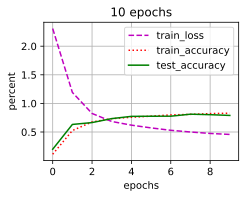

In [31]:
lr, num_epochs = 0.9, 10
train_gpu(net, train_iter, test_iter, num_epochs, lr)